# 1. Импорт и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sktime.utils.plotting import plot_series

temp_df = pd.read_csv("C:\\Users\\Лев\\Projects\\Diploma\\sbp2.csv", sep=';')
temp_df['time'] = pd.to_datetime(temp_df['time'], dayfirst=True)
temp_df = temp_df.sort_values(by=['time'])
temp = pd.DataFrame(pd.date_range(start=temp_df['time'][55215], end=temp_df['time'][0], freq='3 h'), columns=['time'])
temp = temp.set_index('time').join(temp_df.set_index('time'), how='left')
temp = temp['T'].ffill()
temp.index = pd.date_range(start=temp_df['time'][55215], end=temp_df['time'][0], freq='3 h')

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

<Figure size 1500x500 with 0 Axes>

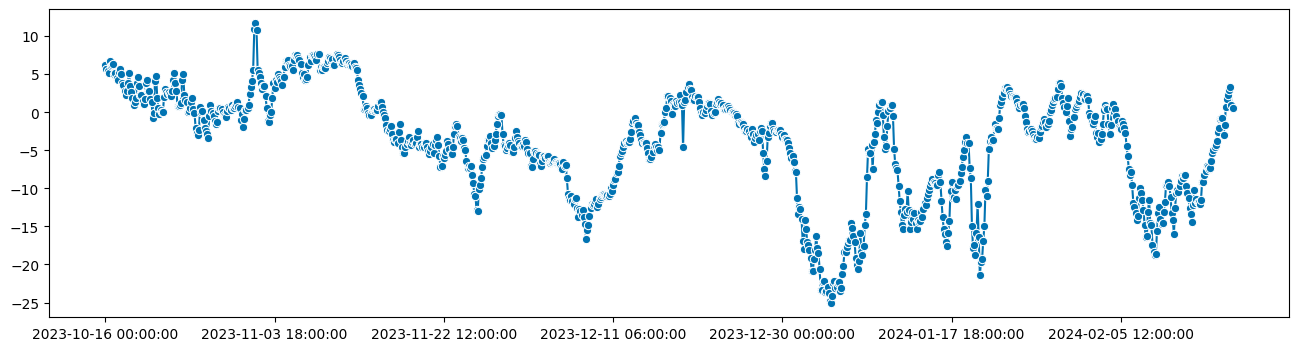

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plot_series(temp[-1000:])

In [2]:
def mae(y_true, y_pred): 
    return np.mean(np.abs(y_true - y_pred))

52504 2920


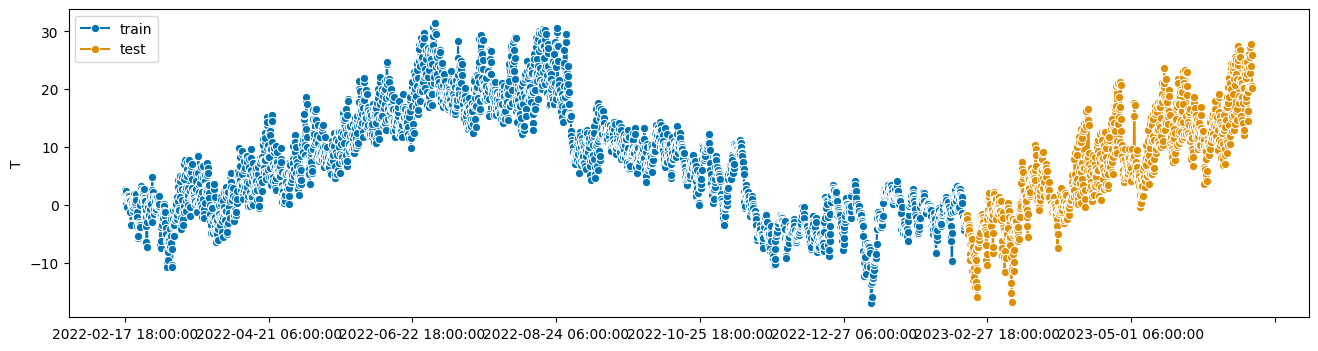

In [3]:
from sktime.forecasting.model_selection import temporal_train_test_split

temp_train, temp_test = temporal_train_test_split(temp, test_size=2920)
plot_series(temp_train[-2922:], temp_test[:1000], labels=['train', 'test'])
print(temp_train.shape[0], temp_test.shape[0])

In [4]:
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(temp_test.index, is_relative=False)

# Наивный прогноз

In [65]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy="last")
forecaster.fit(temp_train)

results = np.array(np.transpose(forecaster.predict(range(1, 25))))

for i in range(358):
    forecaster.update(temp_test[8*i:8*(i+1)], update_params=False)
    results = np.append(results, np.transpose(forecaster.predict(range(1, 25))), axis=0)

In [68]:
results = results.reshape((359, 24))

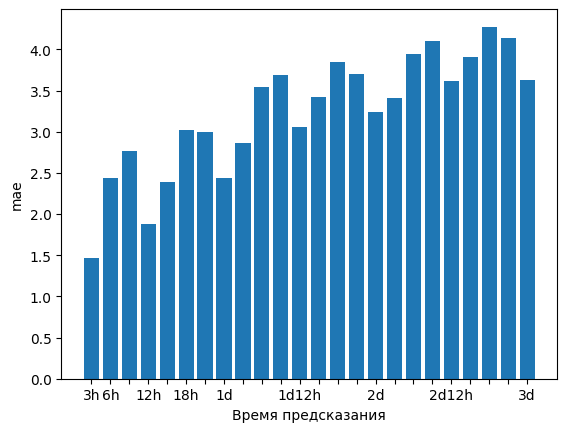

In [70]:
maes = [mae(results[:,j], temp_test.iloc[[8*i + j for i in range(359)]]) for j in range(24)]

import matplotlib.pyplot as plt

names=['3h','6h','               ','12h','              ','18h','             ','1d','            ','           ','          ','1d12h','         ','        ','       ','2d', ' ','  ','   ','2d12h','    ','     ','      ','3d']
plt.bar(x=names, height=maes)
plt.xlabel("Время предсказания")
plt.ylabel("mae")
plt.show()

# EST (AAA) модель

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='T'>)

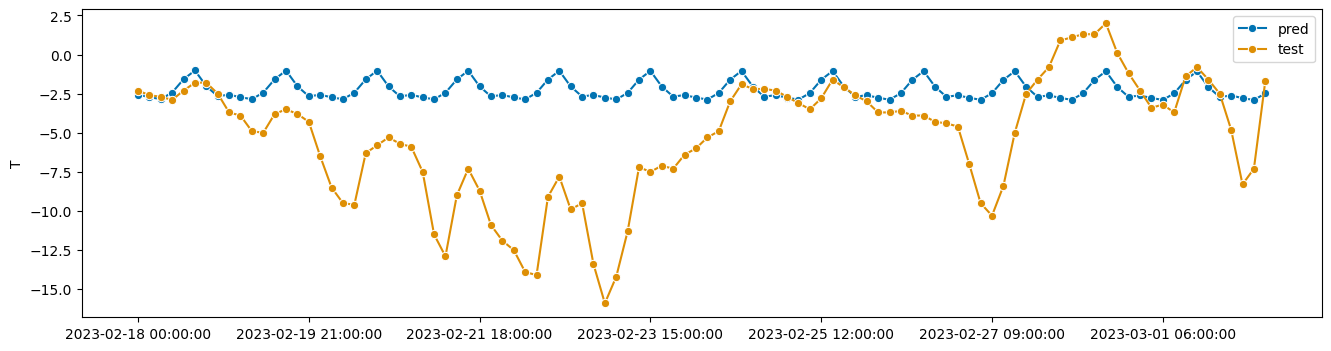

In [24]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = ExponentialSmoothing(trend='add', seasonal='add', sp=8)
forecaster.fit(temp_train[-9000:])

temp_pred = forecaster.predict(fh)
plot_series(temp_pred[:100], temp_test[:100], labels=['pred', 'test'])

In [ ]:
results = np.array([np.transpose(forecaster.predict(range(1, 25)))])

for i in range(358):
    forecaster.update(temp_test[8*i:8*(i+1)], update_params=False)
    results = np.append(results, [np.transpose(forecaster.predict(range(1, 25)))], axis=0)

In [26]:
results.shape

(359, 24)

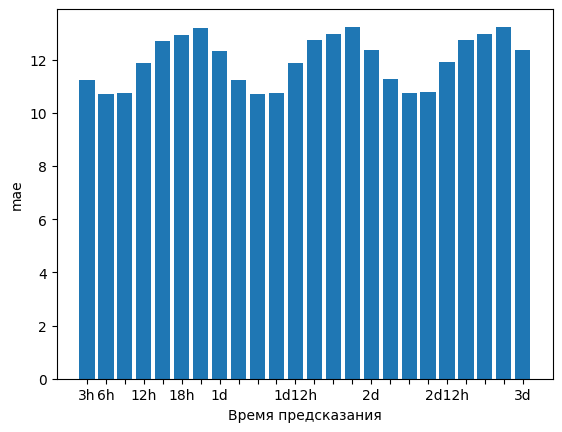

In [27]:
maes = [mae(results[:,j], temp_test.iloc[[8*i + j for i in range(359)]]) for j in range(24)]

import matplotlib.pyplot as plt

names=['3h','6h','               ','12h','              ','18h','             ','1d','            ','           ','          ','1d12h','         ','        ','       ','2d', ' ','  ','   ','2d12h','    ','     ','      ','3d']
plt.bar(x=names, height=maes)
plt.xlabel("Время предсказания")
plt.ylabel("mae")
plt.show()